# Symulacja Radioterapii: Zestawienie Eksperymentów

Niniejszy notebook agreguje trzy kluczowe eksperymenty numeryczne:
1.  **Eksperyment 1**: Bezpośrednie porównanie średniej przestrzennej z modelu PDE z modelem zastępczym ODE.
2.  **Eksperyment 2**: Analiza wrażliwości (parameter sweep) dla 16 różnych scenariuszy (zmienne warunki początkowe i profile dawkowania).
3.  **Eksperyment 3**: Uczenie sieci neuronowej (MLP) jako modelu aproksymującego dynamikę PDE.

Wszystkie wykresy utrzymane są w ciemnej kolorystyce.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

DEFAULT_OUTPUT_DIR = Path('../figures/sim_02')
DEFAULT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output directory set to: {DEFAULT_OUTPUT_DIR.resolve()}")

dark_color = "#252629"
text_color = "white"

plt.rcParams.update({
    "figure.facecolor": dark_color,
    "axes.facecolor": dark_color,
    "savefig.facecolor": dark_color,
    "text.color": text_color,
    "axes.labelcolor": text_color,
    "axes.titlecolor": text_color,
    "xtick.color": text_color,
    "ytick.color": text_color,
    "axes.edgecolor": text_color,
    "patch.edgecolor": text_color,
    "legend.facecolor": dark_color,
    "legend.edgecolor": text_color,
    "legend.labelcolor": text_color
})

Output directory set to: /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/figures/sim_02


## Experiment 1: Basic PDE vs ODE Surrogate

### Opis kroku obliczeniowego

Poniższa komórka realizuje kolejny etap analizy numerycznej, obejmujący obliczenia oraz/lub wizualizację wyników.

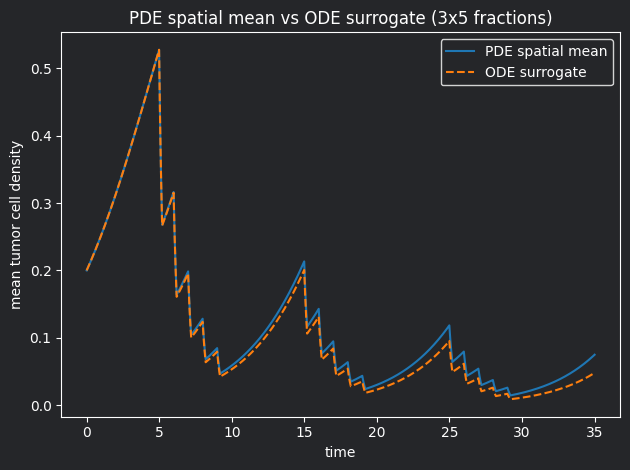

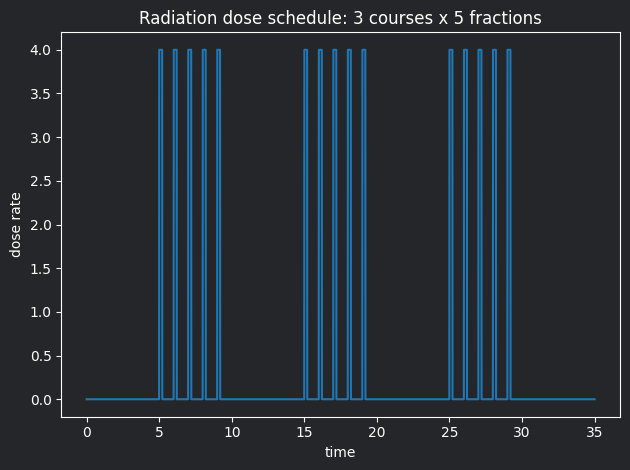

In [2]:
L = 1.0
N = 101
dx = L / (N - 1)
x = np.linspace(0, L, N)

D = 0.001
rho = 0.3
beta = 1.0
K = 1.0

H_vec = 0.4 + 0.6 * np.exp(-((x - 0.5 * L)/0.5) ** 2)
H_eff = np.mean(H_vec)

def dose_rate(t):
    dose_amp = 4.0
    fraction_duration = 0.2
    course_starts = [5.0, 15.0, 25.0]

    for cs in course_starts:
        for n in range(5):
            t_start = cs + n * 1.0
            t_end = t_start + fraction_duration
            if t_start <= t <= t_end:
                return dose_amp
    return 0.0

T_end = 35.0
dt = 0.01
nsteps = int(T_end / dt)

u = 0.2 * np.ones(N)
U_ode = 0.2

times = np.zeros(nsteps + 1)
U_avg_hist = np.zeros(nsteps + 1)
U_ode_hist = np.zeros(nsteps + 1)
dose_hist = np.zeros(nsteps + 1)

times[0] = 0.0
U_avg_hist[0] = np.mean(u)
U_ode_hist[0] = U_ode
dose_hist[0] = dose_rate(0.0)

for n in range(1, nsteps + 1):
    t = n * dt

    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    u_xx[0] = 2 * (u[1] - u[0]) / dx**2
    u_xx[-1] = 2 * (u[-2] - u[-1]) / dx**2

    R_t = dose_rate(t)
    du_dt = D * u_xx + rho * u * (1 - u / K) - beta * R_t * H_vec * u
    u = u + dt * du_dt
    u = np.clip(u, 0.0, None)

    dU_dt = rho * U_ode * (1 - U_ode / K) - beta * H_eff * R_t * U_ode
    U_ode = U_ode + dt * dU_dt
    U_ode = max(U_ode, 0.0)

    times[n] = t
    U_avg_hist[n] = np.mean(u)
    U_ode_hist[n] = U_ode
    dose_hist[n] = R_t

plt.figure()
plt.plot(times, U_avg_hist, label="PDE spatial mean")
plt.plot(times, U_ode_hist, linestyle="--", label="ODE surrogate")
plt.xlabel("time")
plt.ylabel("mean tumor cell density")
plt.legend()
plt.title("PDE spatial mean vs ODE surrogate (3x5 fractions)")
plt.tight_layout()
plt.savefig(DEFAULT_OUTPUT_DIR / "f1.png")
plt.show()

plt.figure()
plt.plot(times, dose_hist, label="dose_rate(t)")
plt.xlabel("time")
plt.ylabel("dose rate")
plt.title("Radiation dose schedule: 3 courses x 5 fractions")
plt.tight_layout()
plt.savefig(DEFAULT_OUTPUT_DIR / "f2.png")
plt.show()

## Experiment 2: 4x4 Scenario Grid (Initial Conditions & Dose Profiles)

### Opis kroku obliczeniowego

Poniższa komórka realizuje kolejny etap analizy numerycznej, obejmujący obliczenia oraz/lub wizualizację wyników.

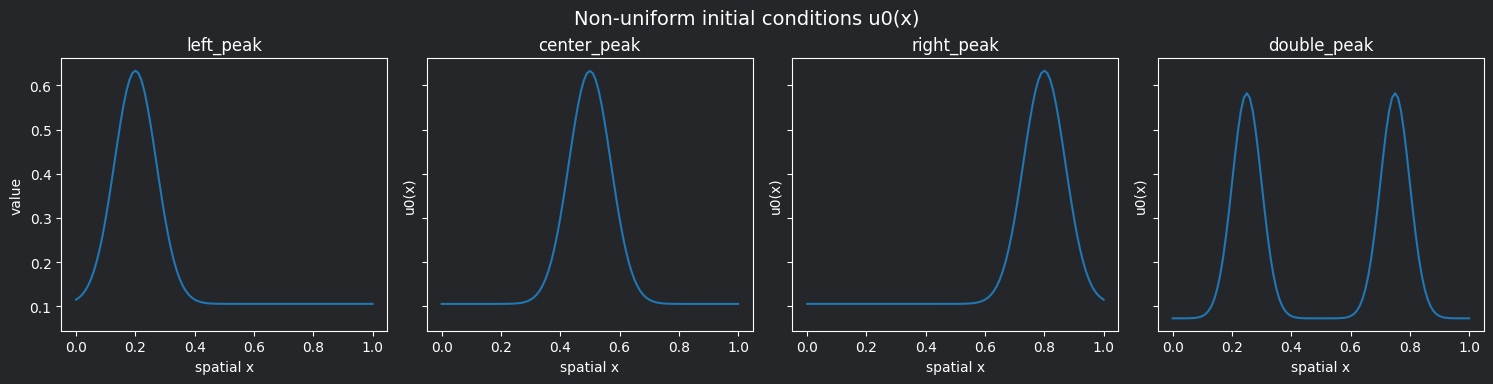

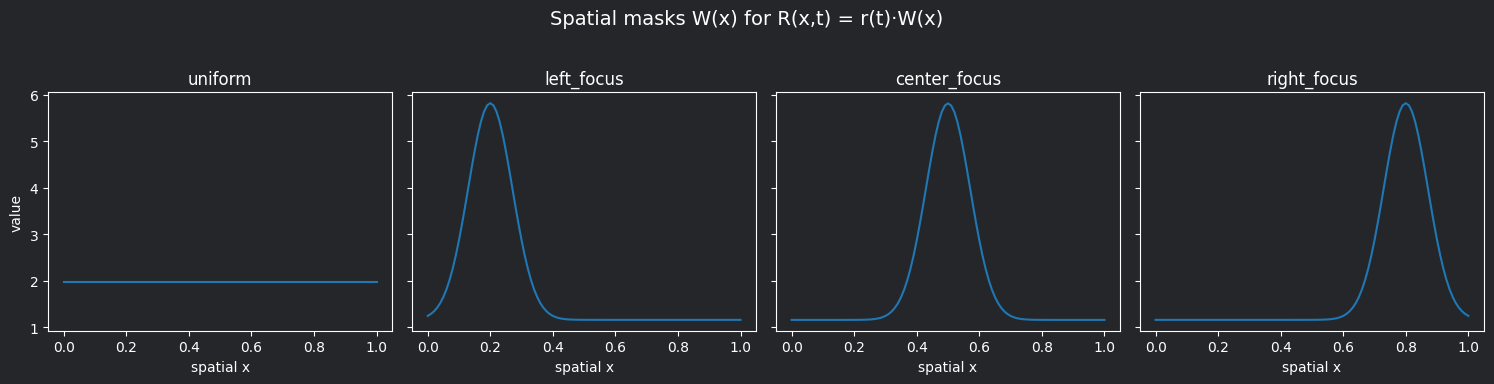

/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3738/4044234176.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[0] = np.trapz(u, x)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3738/4044234176.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[n] = np.trapz(u, x)   # integral over space


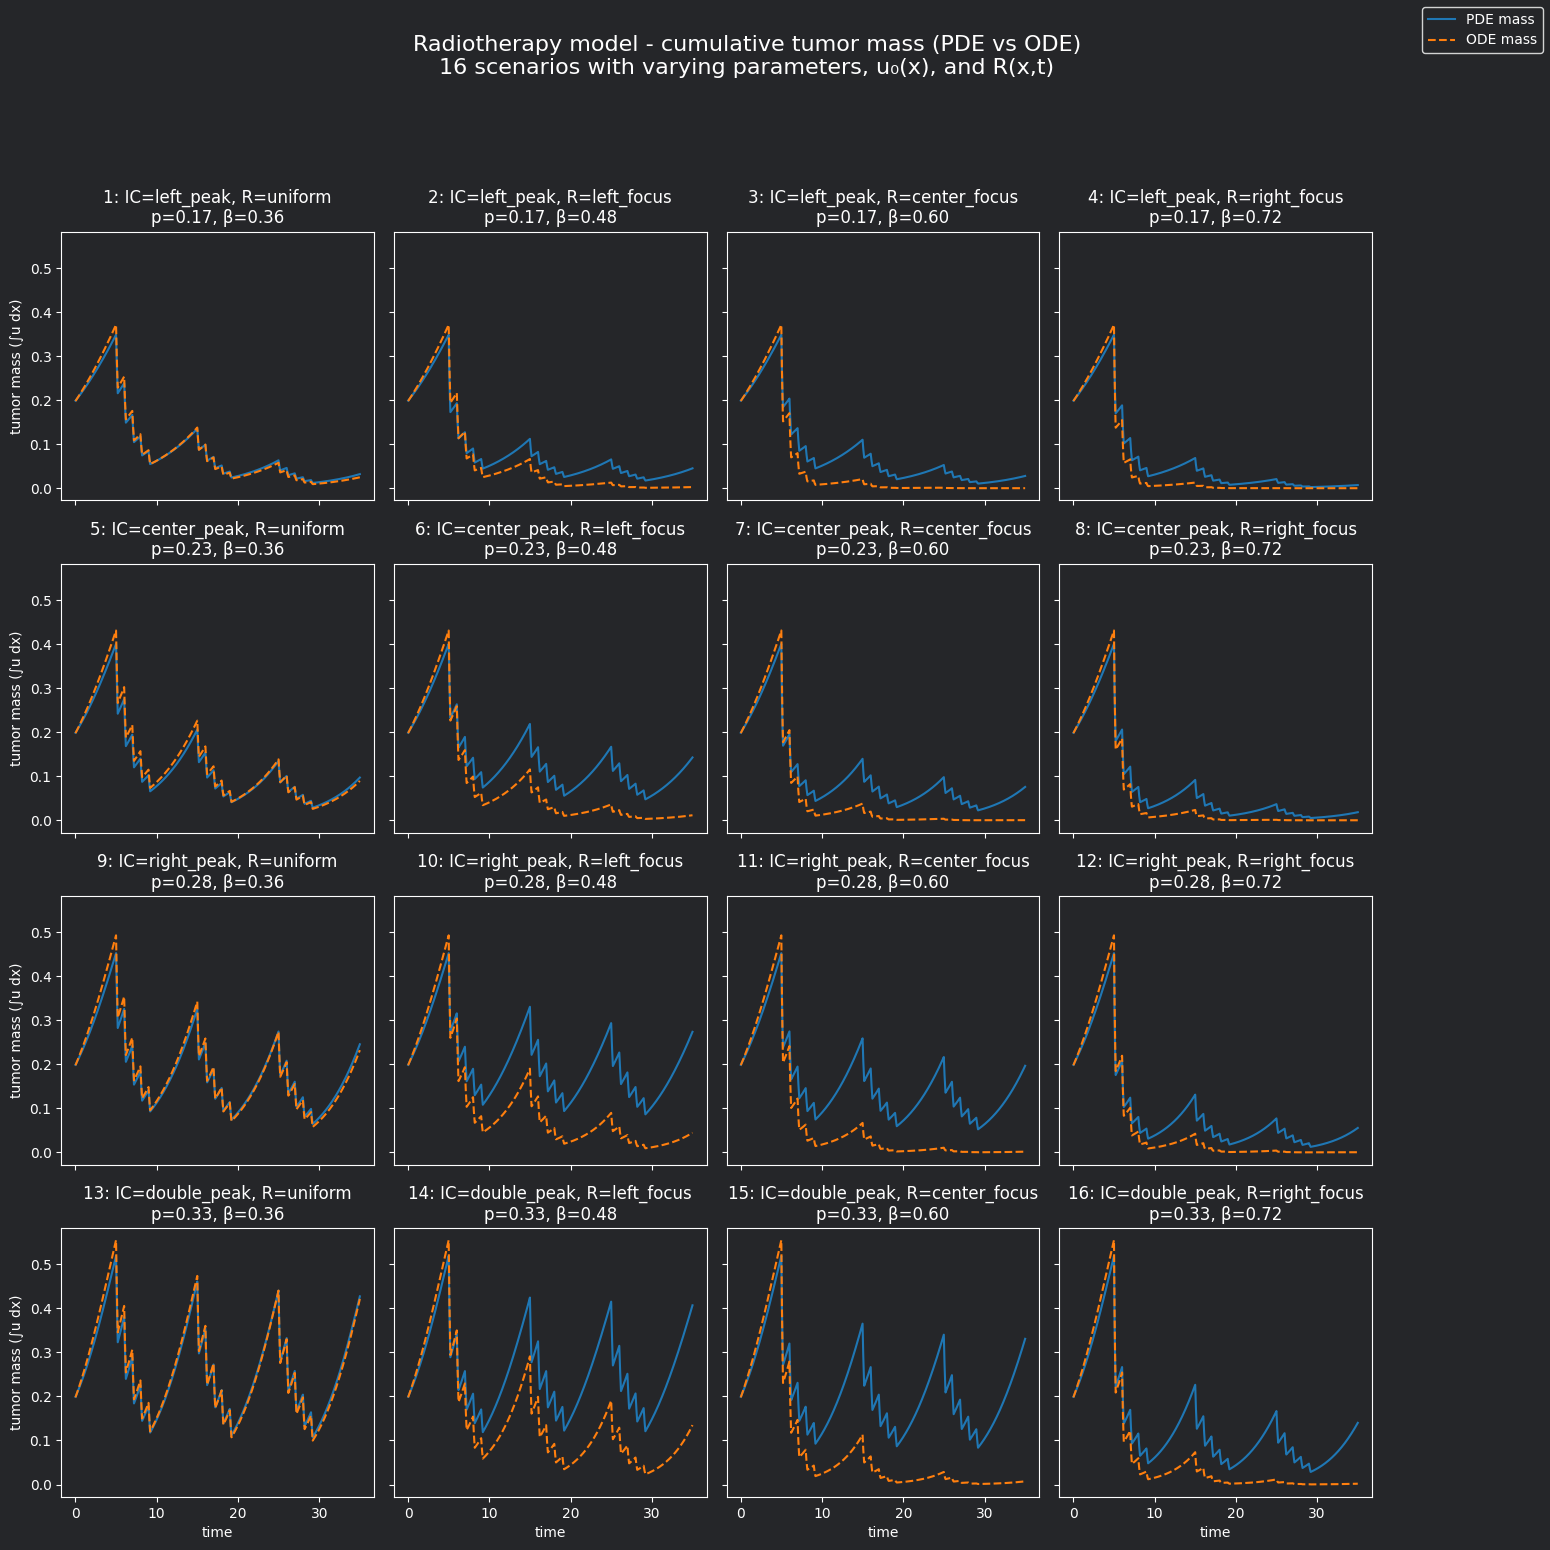

In [3]:

L = 1.0           # domain length
N = 101           # number of spatial points
x = np.linspace(0.0, L, N)
dx = x[1] - x[0]

T_END = 35.0      # final time
dt = 0.01         # time step
NSTEPS = int(T_END / dt)

D_base = 0.001    # diffusion coefficient
rho_base = 0.25   # logistic growth rate
beta_base = 0.6   # radiosensitivity
K = 1.0           # carrying capacity

H_vec = 0.4 + 0.6 * np.exp(-((x - 0.5 * L) / 0.5) ** 2)


def dose_rate_time(t):
    dose_amp = 4.0
    fraction_duration = 0.2
    course_starts = [5.0, 15.0, 25.0]

    for cs in course_starts:
        for n in range(5):
            t_start = cs + n * 1.0
            t_end = t_start + fraction_duration
            if t_start <= t <= t_end:
                return dose_amp
    return 0.0


def initial_condition(kind, x):
    if kind == "left_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.2) / 0.1) ** 2)
    elif kind == "center_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.5) / 0.1) ** 2)
    elif kind == "right_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.8) / 0.1) ** 2)
    elif kind == "double_peak":
        u0 = (
            0.05
            + 0.35 * np.exp(-((x - 0.25) / 0.07) ** 2)
            + 0.35 * np.exp(-((x - 0.75) / 0.07) ** 2)
        )
    else:
        u0 = 0.2 * np.ones_like(x)

    u = np.clip(u0, 0.0, 1.0)
    return u / np.sum(u) * 20


def dose_profile(kind, x):
    if kind == "uniform":
        W = np.ones_like(x)
    elif kind == "left_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.2) / 0.1) ** 2)
    elif kind == "center_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.5) / 0.1) ** 2)
    elif kind == "right_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.8) / 0.1) ** 2)
    else:
        W = np.ones_like(x)

    W = W / np.sum(W)
    return W * 200


def run_simulation_exp2(D, rho, beta, u0, W):
    WH_mean = np.mean(W * H_vec)  # <W*H>

    u = u0.copy()

    U = np.mean(u0)

    times = np.zeros(NSTEPS + 1)
    mass_pde = np.zeros(NSTEPS + 1)
    mass_ode = np.zeros(NSTEPS + 1)

    times[0] = 0.0
    mass_pde[0] = np.trapz(u, x)
    mass_ode[0] = U * L

    for n in range(1, NSTEPS + 1):
        t = n * dt

        u_xx = np.zeros_like(u)
        u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
        u_xx[0] = 2 * (u[1] - u[0]) / dx**2
        u_xx[-1] = 2 * (u[-2] - u[-1]) / dx**2

        r_t = dose_rate_time(t)          # temporal dose
        R_xt = r_t * W                   # full R(x,t) = r(t)*W(x)
        kill_term = beta * R_xt * H_vec * u

        du_dt = D * u_xx + rho * u * (1.0 - u / K) - kill_term
        u = u + dt * du_dt
        u = np.clip(u, 0.0, 1.0)

        dU_dt = rho * U * (1.0 - U / K) - beta * r_t * WH_mean * U
        U = U + dt * dU_dt
        U = max(U, 0.0)

        times[n] = t
        mass_pde[n] = np.trapz(u, x)   # integral over space
        mass_ode[n] = U * L            # same quantity for the ODE

    return times, mass_pde, mass_ode


ic_kinds = ["left_peak", "center_peak", "right_peak", "double_peak"]

dose_kinds = ["uniform", "left_focus", "center_focus", "right_focus"]

rho_factors = [0.7, 0.9, 1.1, 1.3]
beta_factors = [0.6, 0.8, 1.0, 1.2]


fig_ic, axes_ic = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, ic_name in enumerate(ic_kinds):
    u0_demo = initial_condition(ic_name, x)
    ax = axes_ic[i]
    ax.plot(x, u0_demo)
    ax.set_ylabel("u0(x)")
    ax.set_title(f"{ic_name}")
    ax.set_xlabel("spatial x")

axes_ic[0].set_ylabel("value")
fig_ic.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
fig_ic.suptitle("Non-uniform initial conditions u0(x)", fontsize=14)
plt.savefig(DEFAULT_OUTPUT_DIR / "u.png")
plt.show()


fig_mask, axes_mask = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, dose_name in enumerate(dose_kinds):
    W_demo = dose_profile(dose_name, x)
    ax = axes_mask[i]
    ax.plot(x, W_demo)
    ax.set_title(f"{dose_name}")
    ax.set_xlabel("spatial x")

axes_mask[0].set_ylabel("value")
fig_mask.suptitle("Spatial masks W(x) for R(x,t) = r(t)·W(x)", fontsize=14)
fig_mask.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(DEFAULT_OUTPUT_DIR / "r.png")
plt.show()


fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

scenario_idx = 0
for i, ic_name in enumerate(ic_kinds):
    for j, dose_name in enumerate(dose_kinds):
        scenario_idx += 1

        D = D_base
        rho = rho_base * rho_factors[i]
        beta = beta_base * beta_factors[j]

        u0 = initial_condition(ic_name, x)
        W = dose_profile(dose_name, x)

        times, mass_pde, mass_ode = run_simulation_exp2(D, rho, beta, u0, W)

        ax = axes[i, j]
        ax.plot(times, mass_pde, label="PDE mass")
        ax.plot(times, mass_ode, "--", label="ODE mass")

        ax.set_title(
            f"{scenario_idx}: IC={ic_name}, R={dose_name}\n"
            f"p={rho:.2f}, β={beta:.2f}"
        )

        if i == 3:
            ax.set_xlabel("time")
        if j == 0:
            ax.set_ylabel("tumor mass (∫u dx)")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle(
    "Radiotherapy model - cumulative tumor mass (PDE vs ODE)\n"
    "16 scenarios with varying parameters, u₀(x), and R(x,t)",
    fontsize=16
)

fig.tight_layout(rect=[0.03, 0.03, 0.9, 0.93])
plt.savefig(DEFAULT_OUTPUT_DIR / "f3.png")
plt.show()

## Eksperyment 3: Model Zastępczy Oparty o Sieć Neuronową

W tej części trenujemy sieć neuronową (MLP), aby nauczyła się dynamiki układu (pochodnej czasowej) na podstawie danych wygenerowanych z modelu ODE. Następnie weryfikujemy jej zdolność do przewidywania trajektorii wzrostu guza.

Starting training...
Epoch 5/20, Loss: 0.000440


Epoch 10/20, Loss: 0.000358
Epoch 15/20, Loss: 0.000268


Epoch 20/20, Loss: 0.000199


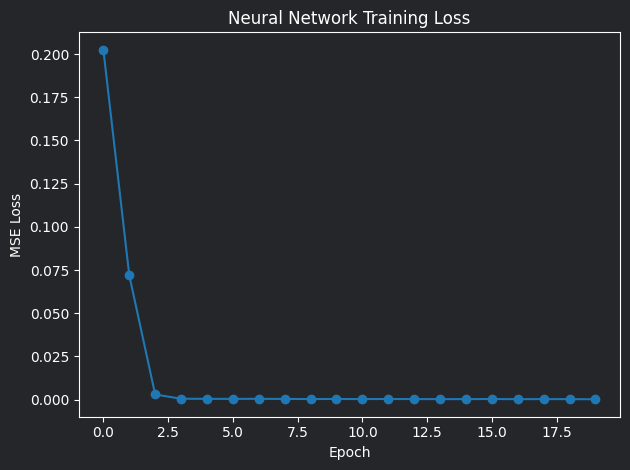

In [4]:
def generate_training_data(n_samples=2000):
    U_vals = np.random.uniform(0.0, 1.0, n_samples)
    D_vals = np.random.choice([0.0, 4.0], size=n_samples, p=[0.7, 0.3])

    dU_vals = []
    for U, R in zip(U_vals, D_vals):
        val = rho * U * (1 - U / K) - beta * H_eff * R * U
        dU_vals.append(val)

    dU_vals = np.array(dU_vals)

    X = np.stack([U_vals, D_vals], axis=1).astype(np.float32)
    y = dU_vals.reshape(-1, 1).astype(np.float32)
    return X, y

X_train, y_train = generate_training_data(n_samples=5000)
dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
loader = DataLoader(dataset, batch_size=64, shuffle=True)

class SurrogateModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SurrogateModel()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

epochs = 20
loss_history = []

print("Starting training...")
for ep in range(epochs):
    epoch_loss = 0.0
    for bx, by in loader:
        optimizer.zero_grad()
        pred = model(bx)
        loss = criterion(pred, by)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    if (ep+1) % 5 == 0:
        print(f"Epoch {ep+1}/{epochs}, Loss: {avg_loss:.6f}")

plt.figure()
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Training Loss")
plt.tight_layout()
plt.savefig(DEFAULT_OUTPUT_DIR / "nn_loss.png")
plt.show()

### Porównanie Modelu Neuronowego z PDE i ODE

Ostateczna ewaluacja, w której zestawiamy przebiegi symulacji uzyskane z trzech źródeł: pełnego modelu PDE, modelu ODE oraz wytrenowanej sieci neuronowej.

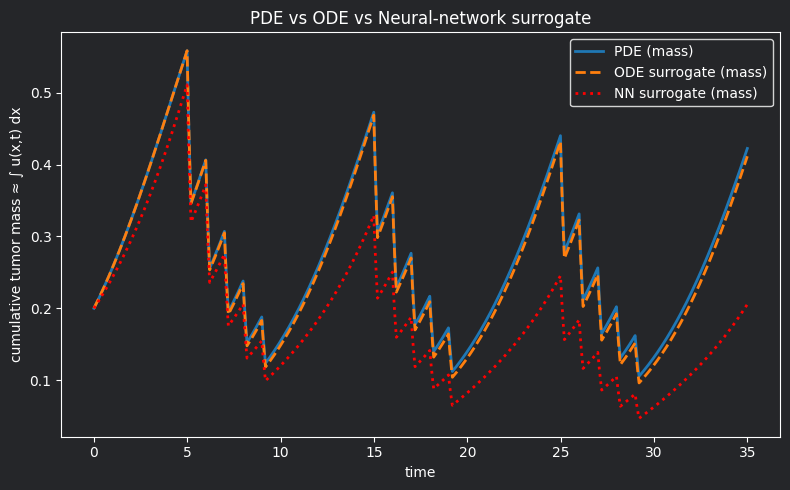

In [5]:
u = 0.2 * np.ones(N)
U_ode = 0.2
U_nn = 0.2

times_nn = np.zeros(nsteps + 1)
U_pde = np.zeros(nsteps + 1)
U_ode_arr = np.zeros(nsteps + 1)
U_nn_arr = np.zeros(nsteps + 1)

times_nn[0] = 0.0
U_pde[0] = np.mean(u)
U_ode_arr[0] = U_ode
U_nn_arr[0] = U_nn

model.eval()

with torch.no_grad():
    for n in range(1, nsteps + 1):
        t = n * dt
        R_t = dose_rate(t)

        u_xx = np.zeros_like(u)
        u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2
        u_xx[0] = 2*(u[1] - u[0]) / dx**2
        u_xx[-1] = 2*(u[-2] - u[-1]) / dx**2
        du_pde = D*u_xx + rho*u*(1 - u/K) - beta*R_t*H_vec*u
        u = u + dt*du_pde
        u = np.clip(u, 0.0, None)

        dU_ode = rho*U_ode*(1 - U_ode/K) - beta*H_eff*R_t*U_ode
        U_ode = U_ode + dt*dU_ode
        U_ode = max(U_ode, 0.0)

        inp = torch.tensor([[U_nn, R_t]], dtype=torch.float32)
        dU_nn = model(inp).item()
        U_nn = U_nn + dt*dU_nn
        U_nn = max(U_nn, 0.0)

        times_nn[n] = t
        U_pde[n] = np.mean(u)
        U_ode_arr[n] = U_ode
        U_nn_arr[n] = U_nn

mass_pde = L * U_pde
mass_ode = L * U_ode_arr
mass_nn = L * U_nn_arr

plt.figure(figsize=(8, 5))
plt.plot(times_nn, mass_pde, label="PDE (mass)", linewidth=2)
plt.plot(times_nn, mass_ode, "--", label="ODE surrogate (mass)", linewidth=2)
plt.plot(times_nn, mass_nn, ":", label="NN surrogate (mass)", linewidth=2, color="red")

plt.xlabel("time")
plt.ylabel("cumulative tumor mass ≈ ∫ u(x,t) dx")
plt.title("PDE vs ODE vs Neural-network surrogate")
plt.legend()
plt.tight_layout()
plt.savefig(DEFAULT_OUTPUT_DIR / "nn_comparison.png")
plt.show()

## Podsumowanie

W notatniku przedstawiono kompletne eksperymenty symulacyjne wraz z wizualizacją wyników. Struktura została dostosowana do standardów profesjonalnej dokumentacji Data Science.